## Ticket Centered Analysis

In [87]:
# pretty print all cell's output and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 15})
sns.set_style('whitegrid')
%matplotlib notebook

In [2]:
df = pd.read_csv('../data/ticket_drivers.csv')

### Top 5 ticket inq types by volume

In [3]:
df.account_number.nunique()

5325

In [4]:
df.policy_number.nunique()

5527

In [5]:
df.groupby('policy_number')['ts'].count().sort_values(ascending=False).sum()

6466

In [9]:
((df.groupby('inquiry_type')['ts'].count().sort_values(ascending=False)).cumsum()/(
    df.groupby('inquiry_type')['ts'].count().sort_values(ascending=False)).sum())[:10]

inquiry_type
endorsements                      0.269682
cancellations                     0.518789
loss_runs                         0.643258
billing_inquiries                 0.758374
document_requests                 0.800034
reinstatement_request             0.831491
outbound_notice__reinstatement    0.860398
renewals                          0.878592
miscellaneous_na                  0.894066
bind_requests                     0.907669
Name: ts, dtype: float64

In [12]:
top5_inq = df.groupby('inquiry_type')['ts'].count().sort_values(ascending=False)[:5].index.values

In [13]:
top5_inq

array(['endorsements', 'cancellations', 'loss_runs', 'billing_inquiries',
       'document_requests'], dtype=object)

### When in policy cycle do tickets occur?

Except for loss_runs:  
- For the top 5 inq types by volume ~30-40% of tickets occur within the first 60 days of policy  
- The next 40% of tickets occur 2-12 months after policy start/renewal

<IPython.core.display.Javascript object>


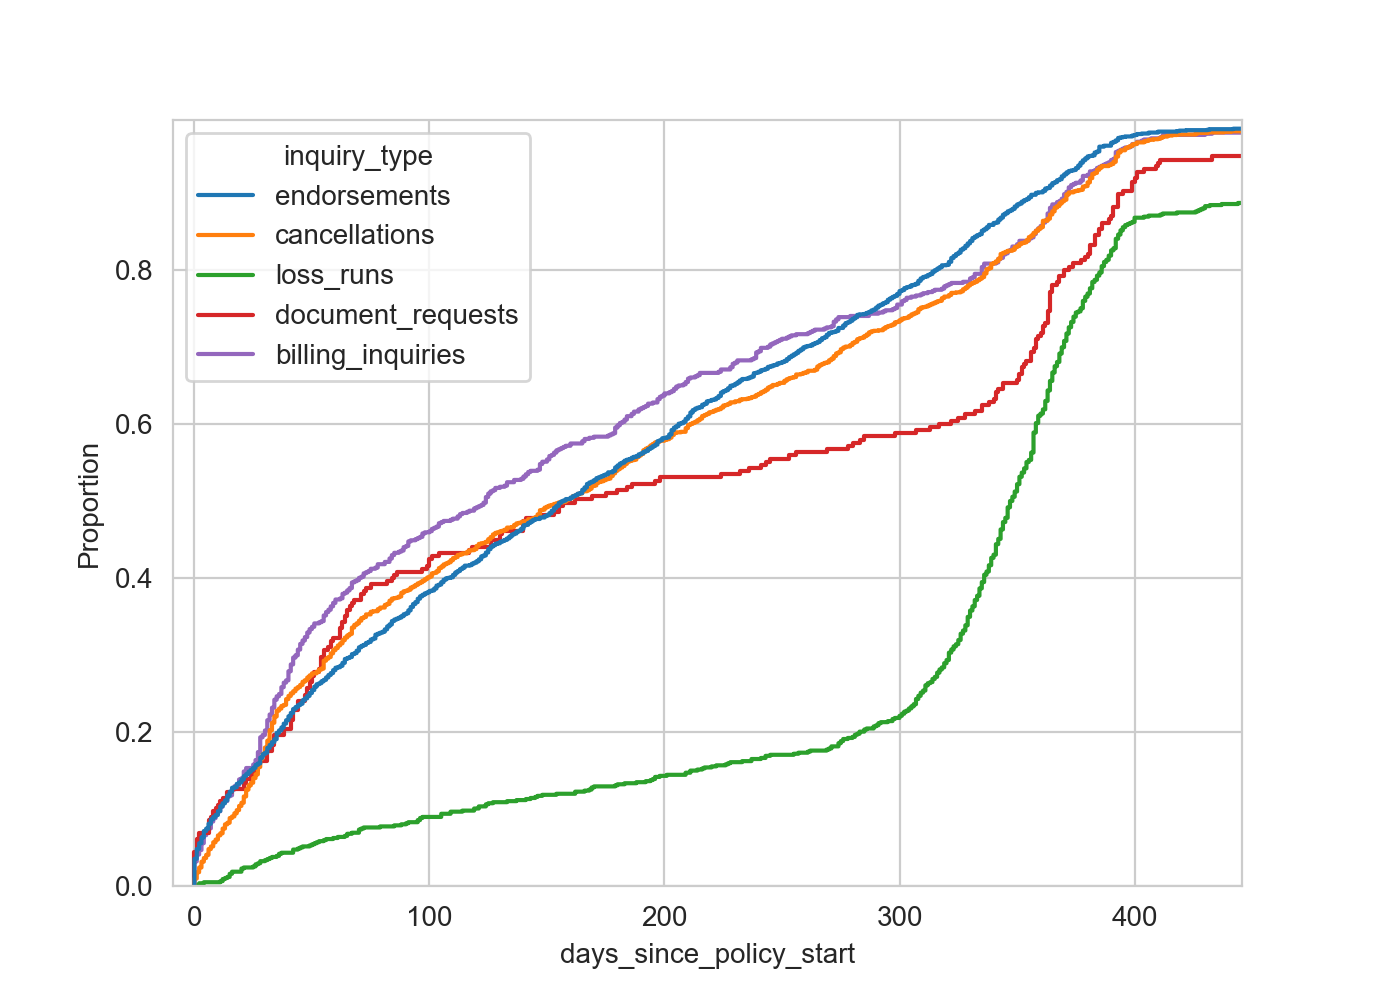

<AxesSubplot:xlabel='days_since_policy_start', ylabel='Proportion'>

In [16]:
sns.ecdfplot(data=df[df.inquiry_type.isin(top5_inq)], hue='inquiry_type',x='days_since_policy_start')

In [15]:
top5_inq

array(['endorsements', 'cancellations', 'loss_runs', 'billing_inquiries',
       'document_requests'], dtype=object)

In [108]:
df[filt].events_before.value_counts().cumsum().reset_index()

index  events_before
0               {null,null,policy_action_new_business}             25
1       {null,policy_action_renewal,delinquency_start}             45
2                                     {null,null,null}             62
3      {null,policy_action_new_business,sms_subscribe}             73
4    {email_new_invoice_false,email_new_invoice_fal...             81
..                                                 ...            ...
105  {invoice_due,invoice_due,policy_action_endorse...            261
106  {email_payment_confirmation_false,email_paymen...            262
107  {delinquency_start,email_new_invoice_true,zend...            263
108  {sms_subscribe,policy_action_endorsement,invoi...            264
109  {null,policy_action_new_business,email_new_inv...            265

[110 rows x 2 columns]

In [17]:
def days_since_policy_start_bucket(n_days):
    if n_days <= 30:
        return 0
    elif n_days>30 and n_days<=60:
        return 1
    elif n_days>60 and n_days<=90:
        return 2
    else:
        return 3

In [18]:
df['days_since_policy_start_bucket'] = df.days_since_policy_start.map(lambda x: days_since_policy_start_bucket(x))

In [ ]:
df.rename(columns={})

In [35]:
def make_report(inquiry_type, topN=5):
    def return_counts(df, filt):
        event_counts = df[filt].events_before.value_counts()
        normed_cume = (event_counts/event_counts.sum()).cumsum()
        merged = event_counts.reset_index().merge(
            normed_cume.reset_index(), on='index', suffixes=('_count', '_cumulative_frac'))
        return merged.rename(columns={'events_before_count': 'num_tickets', 
                                      'events_before_cumulative_frac': 'cumulative_frac_tickets'}
                            )

    # filter to desired inquiry type
    it_df = df[df.inquiry_type == inquiry_type].copy()

    print(f"INQUIRY TYPE: {inquiry_type}")

    print("Ticket Count Over Time (<=30, 31-60, 61-90, 90+ days)------")
    time_counts = it_df.groupby('days_since_policy_start_bucket')[
        'account_number'].count()
    normed_cume_time_counts = (time_counts/time_counts.sum())
    merged_tc = time_counts.reset_index().merge(
        normed_cume_time_counts.reset_index(), on='days_since_policy_start_bucket', suffixes=('_count', '_frac'))
    print(merged_tc.rename(columns={
          'account_number_count': 'num_tickets', 'account_number_frac': 'frac_tickets'}))
    print("")

    print("Over all time--------------")
    filt = (it_df.days_since_policy_start_bucket >= 0)
    res = return_counts(it_df, filt)
    print(res[:topN])
    print("")

    print("First 30 days after policy start--------")
    filt = (it_df.days_since_policy_start_bucket == 0)
    res = return_counts(it_df, filt)
    print(res[:topN])
    print("")

    print("31 - 60 days---------")
    filt = (it_df.days_since_policy_start_bucket == 1)
    res = return_counts(it_df, filt)
    print(res[:topN])
    print("")

    print("61+ days-------------")
    filt = (it_df.days_since_policy_start_bucket >= 2)
    res = return_counts(it_df, filt)
    print(res[:topN])
    print("")

In [36]:
pd.options.display.max_colwidth = 100

In [37]:
make_report('endorsements', topN=7)

INQUIRY TYPE: endorsements
Ticket Count Over Time (<=30, 31-60, 61-90, 90+ days)------
   days_since_policy_start_bucket  num_tickets  frac_tickets
0                               0          275      0.173392
1                               1          175      0.110340
2                               2          112      0.070618
3                               3         1024      0.645649

Over all time--------------
                                              index  num_tickets  \
0             {invoice_due,invoice_due,invoice_due}          155   
1    {delinquency_noc,delinquency_exit,invoice_due}           83   
2     {null,policy_action_new_business,invoice_due}           65   
3             {email_false,invoice_due,email_false}           43   
4  {delinquency_start,delinquency_exit,invoice_due}           39   
5              {email_true,invoice_due,email_false}           37   
6             {invoice_due,email_false,email_false}           36   

   cumulative_frac_tickets  
0    

In [38]:
make_report('cancellations', topN=7)

INQUIRY TYPE: cancellations
Ticket Count Over Time (<=30, 31-60, 61-90, 90+ days)------
   days_since_policy_start_bucket  num_tickets  frac_tickets
0                               0          264      0.180205
1                               1          189      0.129010
2                               2          109      0.074403
3                               3          903      0.616382

Over all time--------------
                                                      index  num_tickets  \
0                     {invoice_due,invoice_due,invoice_due}          185   
1             {null,policy_action_new_business,invoice_due}           94   
2            {delinquency_noc,delinquency_exit,invoice_due}           83   
3  {delinquency_warning_email,delinquency_exit,invoice_due}           36   
4          {delinquency_start,delinquency_exit,invoice_due}           32   
5            {null,policy_action_renewal,delinquency_start}           27   
6                  {invoice_due,invoice_due,ze

In [39]:
make_report('loss_runs', topN=7)

INQUIRY TYPE: loss_runs
Ticket Count Over Time (<=30, 31-60, 61-90, 90+ days)------
   days_since_policy_start_bucket  num_tickets  frac_tickets
0                               0           25      0.034153
1                               1           21      0.028689
2                               2           14      0.019126
3                               3          672      0.918033

Over all time--------------
                                                      index  num_tickets  \
0                     {invoice_due,invoice_due,invoice_due}          145   
1             {null,policy_action_new_business,invoice_due}           57   
2            {delinquency_noc,delinquency_exit,invoice_due}           31   
3          {delinquency_start,delinquency_exit,invoice_due}           27   
4                      {email_true,invoice_due,email_false}           24   
5  {delinquency_warning_email,delinquency_exit,invoice_due}           20   
6                     {invoice_due,email_false,ema

In [41]:
make_report('billing_inquiries', topN=7)

INQUIRY TYPE: billing_inquiries
Ticket Count Over Time (<=30, 31-60, 61-90, 90+ days)------
   days_since_policy_start_bucket  num_tickets  frac_tickets
0                               0          137      0.202363
1                               1          115      0.169867
2                               2           47      0.069424
3                               3          378      0.558346

Over all time--------------
                                                                      index  \
0                                     {invoice_due,invoice_due,invoice_due}   
1                             {null,policy_action_new_business,invoice_due}   
2                 {invoice_due,policy_action_cancellation,delinquency_exit}   
3                            {null,policy_action_renewal,delinquency_start}   
4    {delinquency_reminder_email,delinquency_warning_email,delinquency_noc}   
5                            {delinquency_noc,delinquency_exit,invoice_due}   
6  {delinquency_start

## Policy Event Centered Analysis

In [9]:
!head -n2 ../data/ticket_histories.csv

account_number,event_history,event_ts,policy_number
0000256453,ghrqkr,"{2021-09-13 03:53:25.374000,2021-09-13 07:30:31.405000,2021-09-13 07:31:13.000000,2021-09-29 18:40:27.000000,2021-09-30 03:45:06.729000,2021-09-30 03:45:31.000000}",1ABPTX05127655700


In [11]:
df = pd.read_csv('../data/ticket_histories.csv')

In [22]:
df['timestamps'] = df.event_ts.map(
    lambda x: [pd.to_datetime(i) for i in x.strip('{}').split(',')])

In [24]:
df.drop('event_ts', axis=1, inplace=True)

In [79]:
def event_inds(event_history, event_code:str):
    return np.argwhere(np.array(list(event_history))==event_code).squeeze()

In [46]:
df['ticket_inds'] = df.event_history.map(lambda x: np.argwhere(np.array(list(x))=='q').squeeze())

In [ ]:
df.apply()

### Ticket distribution since policy start/renewal

In [67]:
df.head(2)

account_number            event_history              policy_number  \
0          256453                   ghrqkr          1ABPTX05127655700   
1          521037  gaaaaaqqrrrrrrrrrrrrrra  MORSTAN00001HIBP-21604-01   

                                          timestamps ticket_inds  
0  [2021-09-13 03:53:25.374000, 2021-09-13 07:30:...           3  
1  [2019-07-25 20:42:13.602000, 2019-07-30 00:00:...      [6, 7]

In [60]:
def diff_days(ts_later, ts_earlier):
    return round((ts_later - ts_earlier).total_seconds()/86400, 1)

In [63]:
tdays = df.explode('ticket_inds').apply(lambda x: diff_days(
    x['timestamps'][x['ticket_inds']], x['timestamps'][0]), axis=1)

50% of tickets within first 2 months, afterwards linear growth until end of year

<IPython.core.display.Javascript object>


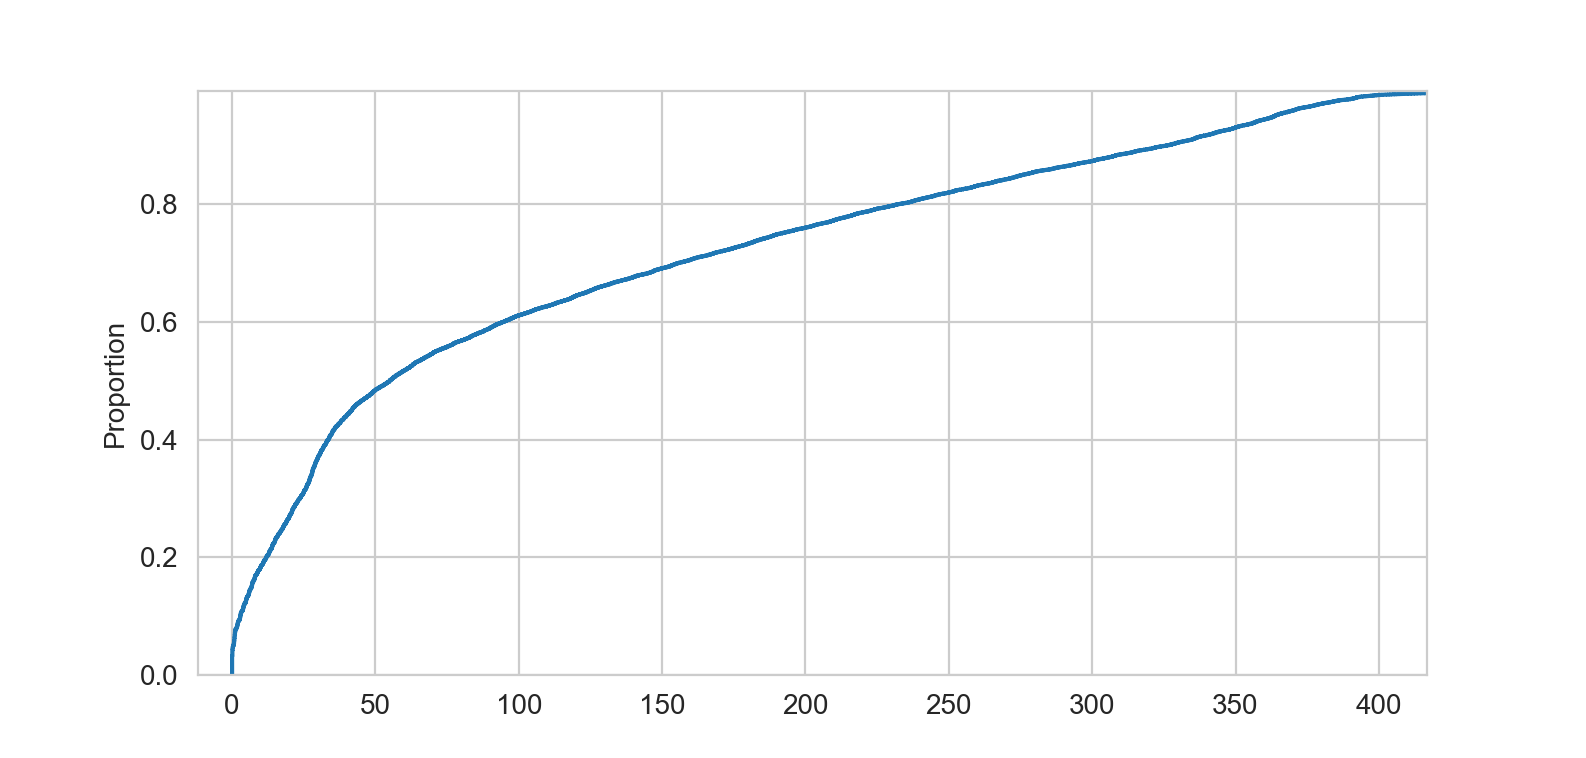

<AxesSubplot:ylabel='Proportion'>

In [66]:
sns.ecdfplot(tdays)

### Ticket probablity by day of year

In [70]:
tdoy = df.explode('ticket_inds').apply(lambda x: x['timestamps'][x['ticket_inds']].dayofyear, axis=1)

Tickets equally likely on any day of year.

<IPython.core.display.Javascript object>


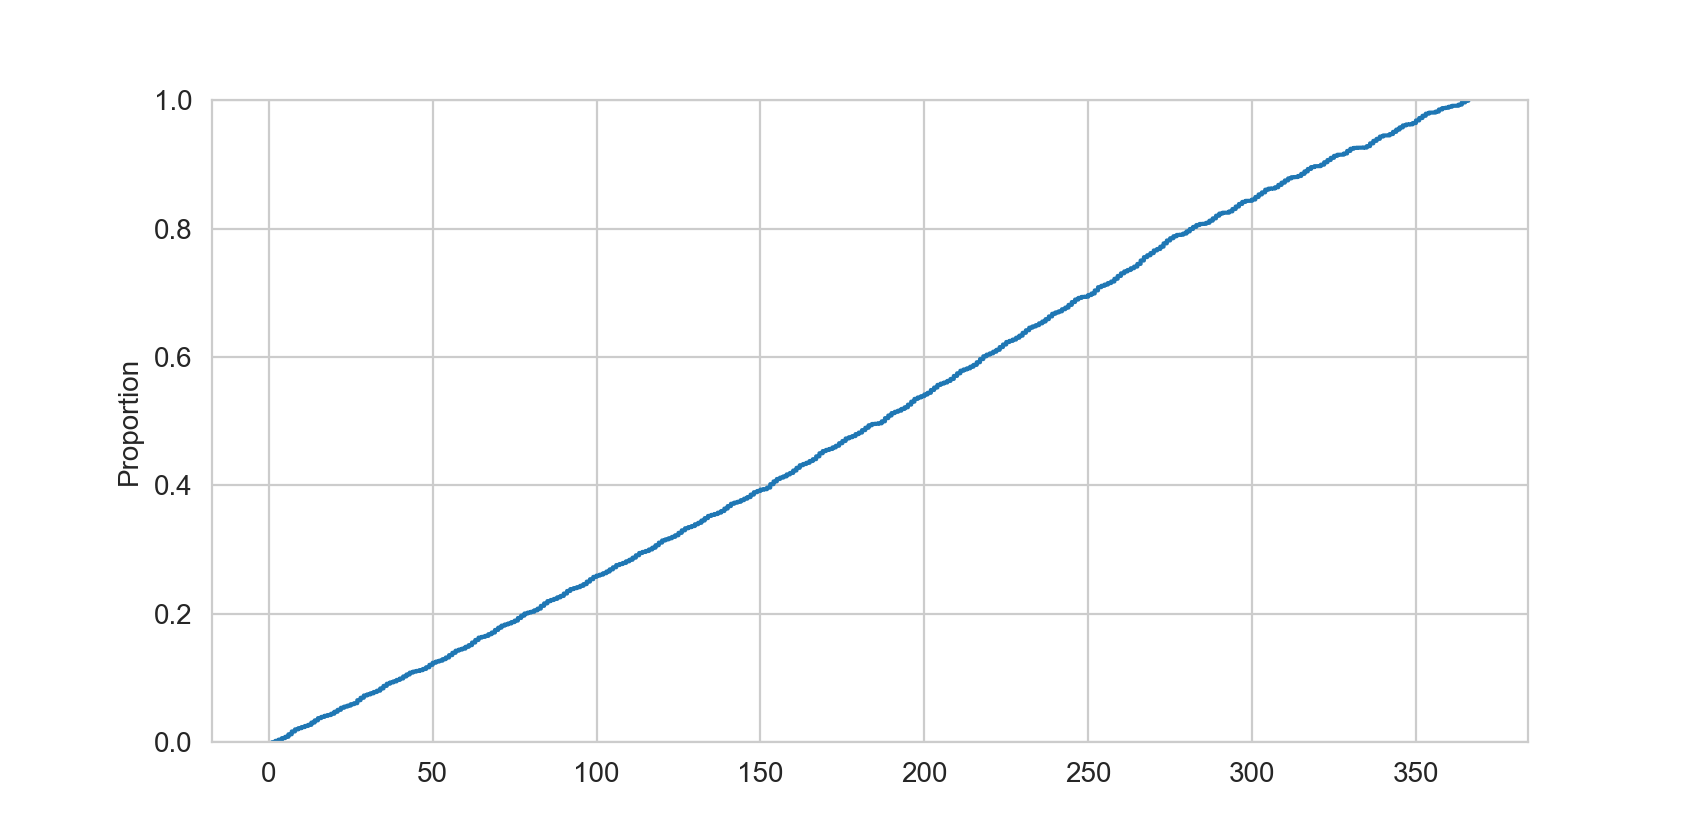

<AxesSubplot:ylabel='Proportion'>

In [73]:
sns.ecdfplot(tdoy)

### Tickets around policy events

In [88]:
for e in list('cdefg'):
    df[df.event_history.str.contains(e)].event_history.map(
        lambda x: event_inds(x, e)).map(np.shape).value_counts()

()      12365
(2,)      916
(3,)       56
(4,)        4
(5,)        1
Name: event_history, dtype: int64

()      2273
(2,)      80
(3,)       3
Name: event_history, dtype: int64

()       12579
(2,)      4998
(3,)      2177
(4,)      1074
(5,)       572
(6,)       253
(7,)       113
(8,)        46
(9,)        23
(10,)       22
(11,)       14
(12,)        5
(14,)        4
(15,)        3
(13,)        2
(21,)        2
(18,)        1
(22,)        1
(20,)        1
(16,)        1
(17,)        1
(19,)        1
(24,)        1
(27,)        1
Name: event_history, dtype: int64

()      19854
(2,)        9
Name: event_history, dtype: int64

()    22729
Name: event_history, dtype: int64

#### new business

In [154]:
df['g_inds'] = df.event_history.map(lambda x: np.argwhere(np.array(list(x))=='g').squeeze())

In [155]:
df['g_inds'] = df['g_inds'].map(lambda x: x if isinstance(x,int) else None).replace({np.nan:None})

In [156]:
df.head(3)

account_number                    event_history              policy_number  \
0          256453                           ghrqkr          1ABPTX05127655700   
1          521037          gaaaaaqqrrrrrrrrrrrrrra  MORSTAN00001HIBP-21604-01   
2          521037  faqqrrrrrahjrrirrahjrkrrliprraa  MORSTAN00001HIBP-21604-02   

                                          timestamps ticket_inds g_inds  
0  [2021-09-13 03:53:25.374000, 2021-09-13 07:30:...           3    0.0  
1  [2019-07-25 20:42:13.602000, 2019-07-30 00:00:...      [6, 7]    0.0  
2  [2020-06-25 13:54:01.242000, 2020-07-25 00:00:...      [2, 3]   None

In [157]:
def diff_days(ts_later, ts_earlier, abs_val=False):
    diff = (ts_later - ts_earlier).total_seconds()/86400
    return round(abs(diff), 1) if abs_val else round(diff, 1)

In [161]:
g_tix_diffs = df.dropna(subset=['g_inds']).explode('ticket_inds').apply(lambda x: diff_days(
    x['timestamps'][x['ticket_inds']], x['timestamps'][int(x['g_inds'])]), axis=1)

Looks the same as plot above as expected

<IPython.core.display.Javascript object>


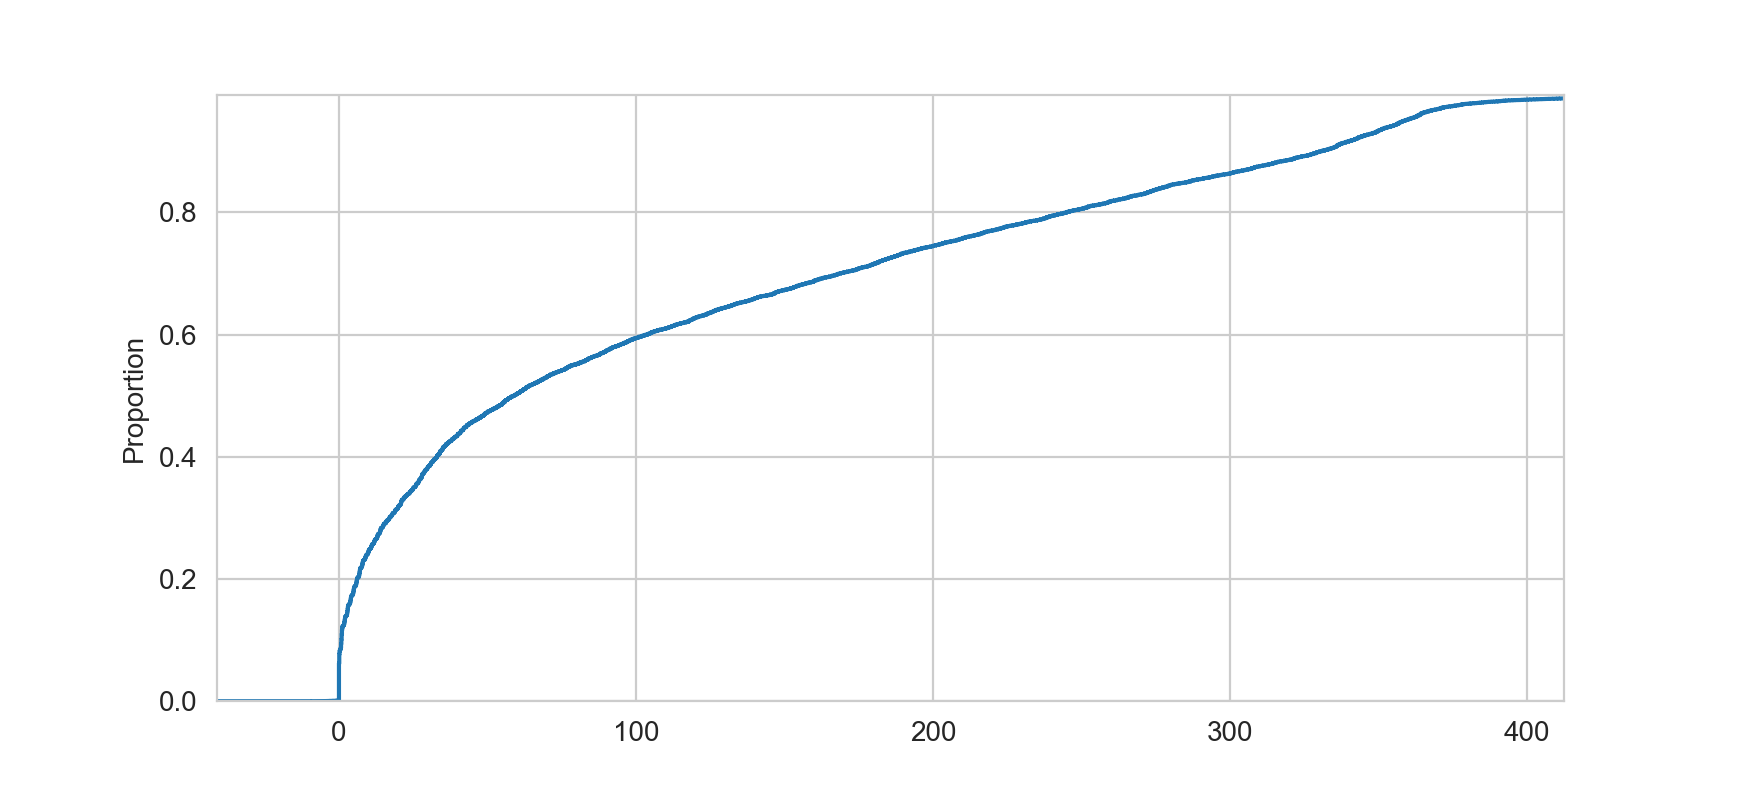

<AxesSubplot:ylabel='Proportion'>

In [164]:
sns.ecdfplot(g_tix_diffs)

#### cancellations

In [184]:
#add index
for e in list('def'):
    col_name = e + '_inds'
    df[col_name] = df.event_history.map(lambda x: np.argwhere(np.array(list(x))==e).squeeze())
    df[col_name] = df[col_name].map(lambda x: x if isinstance(x,int) else None).replace({np.nan:None})

In [166]:
#take only first cancellation event
# df['c_inds'] = df.event_history.map(lambda x: np.argwhere(np.array(list(x))=='c').squeeze())
# df['c_inds'] = df['c_inds'].map(lambda x: x if isinstance(x,int) else None).replace({np.nan:None})

In [185]:
df.head(3)

account_number                    event_history              policy_number  \
0          256453                           ghrqkr          1ABPTX05127655700   
1          521037          gaaaaaqqrrrrrrrrrrrrrra  MORSTAN00001HIBP-21604-01   
2          521037  faqqrrrrrahjrrirrahjrkrrliprraa  MORSTAN00001HIBP-21604-02   

                                          timestamps ticket_inds g_inds  \
0  [2021-09-13 03:53:25.374000, 2021-09-13 07:30:...           3    0.0   
1  [2019-07-25 20:42:13.602000, 2019-07-30 00:00:...      [6, 7]    0.0   
2  [2020-06-25 13:54:01.242000, 2020-07-25 00:00:...      [2, 3]   None   

  c_inds d_inds e_inds f_inds  
0   None   None   None   None  
1   None   None   None   None  
2   None   None   None    0.0

In [157]:
def diff_days(ts_later, ts_earlier, abs_val=False):
    diff = (ts_later - ts_earlier).total_seconds()/86400
    return round(abs(diff), 1) if abs_val else round(diff, 1)

<IPython.core.display.Javascript object>


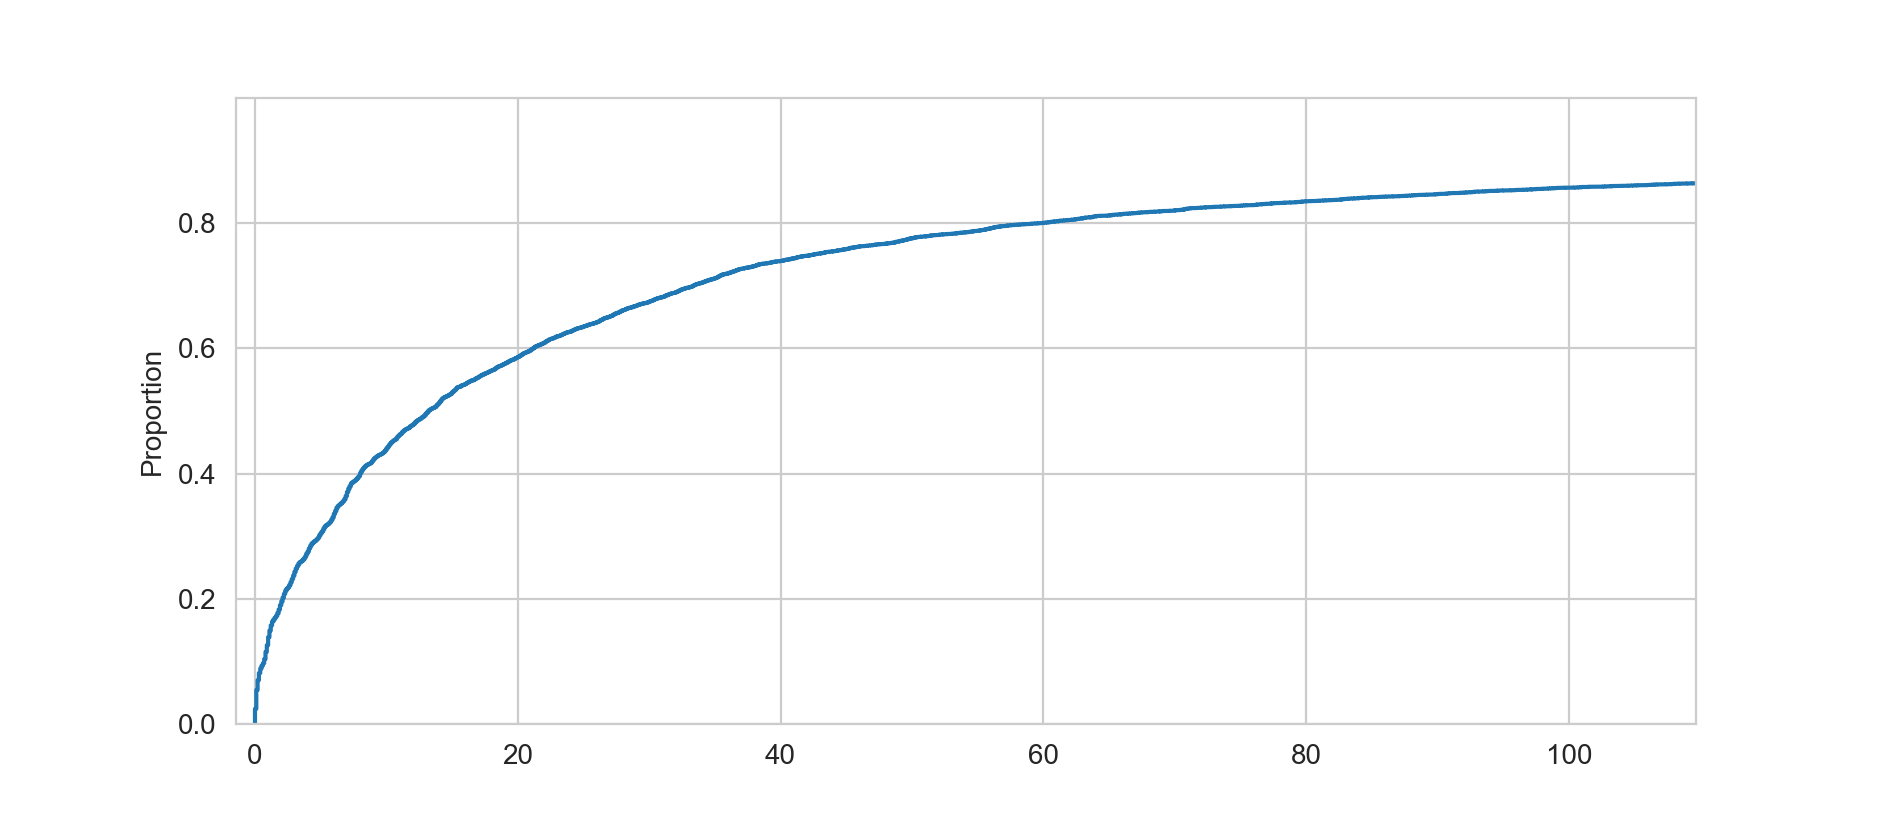

<AxesSubplot:ylabel='Proportion'>

In [183]:
# g_tix_diffs =
sns.ecdfplot(df.dropna(subset=['g_inds', 'c_inds']).explode('ticket_inds').apply(
    lambda x: diff_days(x['timestamps'][x['ticket_inds']], x['timestamps'][int(x['c_inds'])], abs_val=True), axis=1))

### Distance from tickets to every policy event

In [186]:
df.head()

account_number                    event_history              policy_number  \
0          256453                           ghrqkr          1ABPTX05127655700   
1          521037          gaaaaaqqrrrrrrrrrrrrrra  MORSTAN00001HIBP-21604-01   
2          521037  faqqrrrrrahjrrirrahjrkrrliprraa  MORSTAN00001HIBP-21604-02   
3          659842                    fhrkrirqraeqe   CMFRST00001HIBP-36232-02   
4          754369                          gahqjic    PHGRP00001HIBP-46324-01   

                                          timestamps ticket_inds g_inds  \
0  [2021-09-13 03:53:25.374000, 2021-09-13 07:30:...           3    0.0   
1  [2019-07-25 20:42:13.602000, 2019-07-30 00:00:...      [6, 7]    0.0   
2  [2020-06-25 13:54:01.242000, 2020-07-25 00:00:...      [2, 3]   None   
3  [2020-12-15 00:10:09.007000, 2020-12-15 07:31:...     [7, 11]   None   
4  [2020-07-01 18:39:58.964000, 2020-07-29 00:00:...           3    0.0   

  c_inds d_inds e_inds f_inds  
0   None   None   None   None  
1   None   None   None   None  
2   None   None   None    0.0  
3   None   None   None    0.0  
4    6.0   None   None   None

In [201]:
df['ticket_inds'] = df.ticket_inds.map(lambda x: [x] if isinstance(x, int) else x)

In [192]:
events = {"c": "cancellation",
"d": "reinstatement",
"e": "endorsement",
"f": "renewal",
"g": "new_business",
"h": "del_start",
"i": "del_exit"}

In [193]:
from collections import defaultdict

Make rows containing ticket distances from every event type to all tickets

In [480]:
event_ticket_distance_rows = []
for row in df[['event_history', 'timestamps','ticket_inds']].itertuples():
    event_ticket_distances = defaultdict(list)
    for i,event in enumerate(row.event_history):
        if event in events.keys():
            key = events[event]
            #get events ts
            e_ts = row.timestamps[i]
            #find distances to every ticket in the account history
            tix_distances = [diff_days(e_ts, row.timestamps[j],abs_val=False) for j in row.ticket_inds]
            event_ticket_distances[key].extend(tix_distances)
    event_ticket_distance_rows.append(event_ticket_distances)

In [481]:
df['event_ticket_distances'] = pd.Series(event_ticket_distance_rows)

In [235]:
# df.drop(df.filter(regex='^\w{1}_inds').columns.tolist(), axis=1, inplace=True)

In [482]:
df.head(2)

account_number            event_history              policy_number  \
0          256453                   ghrqkr          1ABPTX05127655700   
1          521037  gaaaaaqqrrrrrrrrrrrrrra  MORSTAN00001HIBP-21604-01   

                                          timestamps ticket_inds  \
0  [2021-09-13 03:53:25.374000, 2021-09-13 07:30:...         [3]   
1  [2019-07-25 20:42:13.602000, 2019-07-30 00:00:...      [6, 7]   

                            event_ticket_distances  \
0  {'new_business': [-16.6], 'del_start': [-16.5]}   
1               {'new_business': [-375.9, -375.9]}   

                                    distance_metrics  history_len  
0  {'mean_distance': 16.55, 'event_mean_distances...         17.0  
1  {'mean_distance': 375.9, 'event_mean_distances...        711.1

On average, what is the distance of a ticket to any policy event?  
Overall, and for each inquiry type, what is the distance of a ticket to EOI?  
- for every account history, what is the mean distance of all tickets to EOI?  
- for each event, how does the ticket distance distribution compare to the mean distance? to the all tickets - all events dist?  
- for every account history, which/how many EOI (events of interest) are within N_days of a ticket?

In [483]:
distance_metrics_rows = []
for row in df[['event_ticket_distances']].itertuples():
    distance_metrics = defaultdict(dict)
    d = row.event_ticket_distances.copy()
    
    #mean dist of distances
    all_distances = []
    for d_list in d.values():
        all_distances += d_list
    mean_distance = np.mean(np.abs(all_distances))
    distance_metrics['mean_distance'] = mean_distance
    
    #mean event distance
    means_dict = defaultdict(float)
    for k,v in d.items():
        key = k + '_mean'
        means_dict[key] = np.mean(np.abs(v))
    distance_metrics['event_mean_distances'] = means_dict
    
    #num tickets with 7 days
    week_dict = {}
    for k,v in d.items():
        key = k + '_7days'
        week_dict[key] = Counter([dist<=7 for dist in np.abs(v)])
    distance_metrics['event_7days'] = week_dict
    
    #num tickets with 7 days
    week_dict = {}
    for k,v in d.items():
        key = k + '_1day'
        week_dict[key] = Counter([dist<=1 for dist in np.abs(v)])
    distance_metrics['event_1day'] = week_dict
    
    #add new row
    distance_metrics_rows.append(distance_metrics)

//anaconda3/envs/sklearn/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
//anaconda3/envs/sklearn/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [484]:
df['distance_metrics'] = pd.Series(distance_metrics_rows)

### Analyze metrics

In [485]:
df.head(2)

account_number            event_history              policy_number  \
0          256453                   ghrqkr          1ABPTX05127655700   
1          521037  gaaaaaqqrrrrrrrrrrrrrra  MORSTAN00001HIBP-21604-01   

                                          timestamps ticket_inds  \
0  [2021-09-13 03:53:25.374000, 2021-09-13 07:30:...         [3]   
1  [2019-07-25 20:42:13.602000, 2019-07-30 00:00:...      [6, 7]   

                            event_ticket_distances  \
0  {'new_business': [-16.6], 'del_start': [-16.5]}   
1               {'new_business': [-375.9, -375.9]}   

                                    distance_metrics  history_len  
0  {'mean_distance': 16.55, 'event_mean_distances...         17.0  
1  {'mean_distance': 375.9, 'event_mean_distances...        711.1

#### Distrubtion of mean distance of tickets from every EOI

In [388]:
df.distance_metrics.apply(lambda x: x['mean_distance']).describe()

count    45290.000000
mean        79.589008
std         85.331426
min          0.000000
25%         15.716667
50%         46.917143
75%        122.042424
max       1098.900000
Name: distance_metrics, dtype: float64

On average (over all account histories), a ticket occurs 80 days away from our EOI (events of interest). 

events = "cancellation","reinstatement","endorsement","renewal","new_business","del_start","del_exit"}

<IPython.core.display.Javascript object>


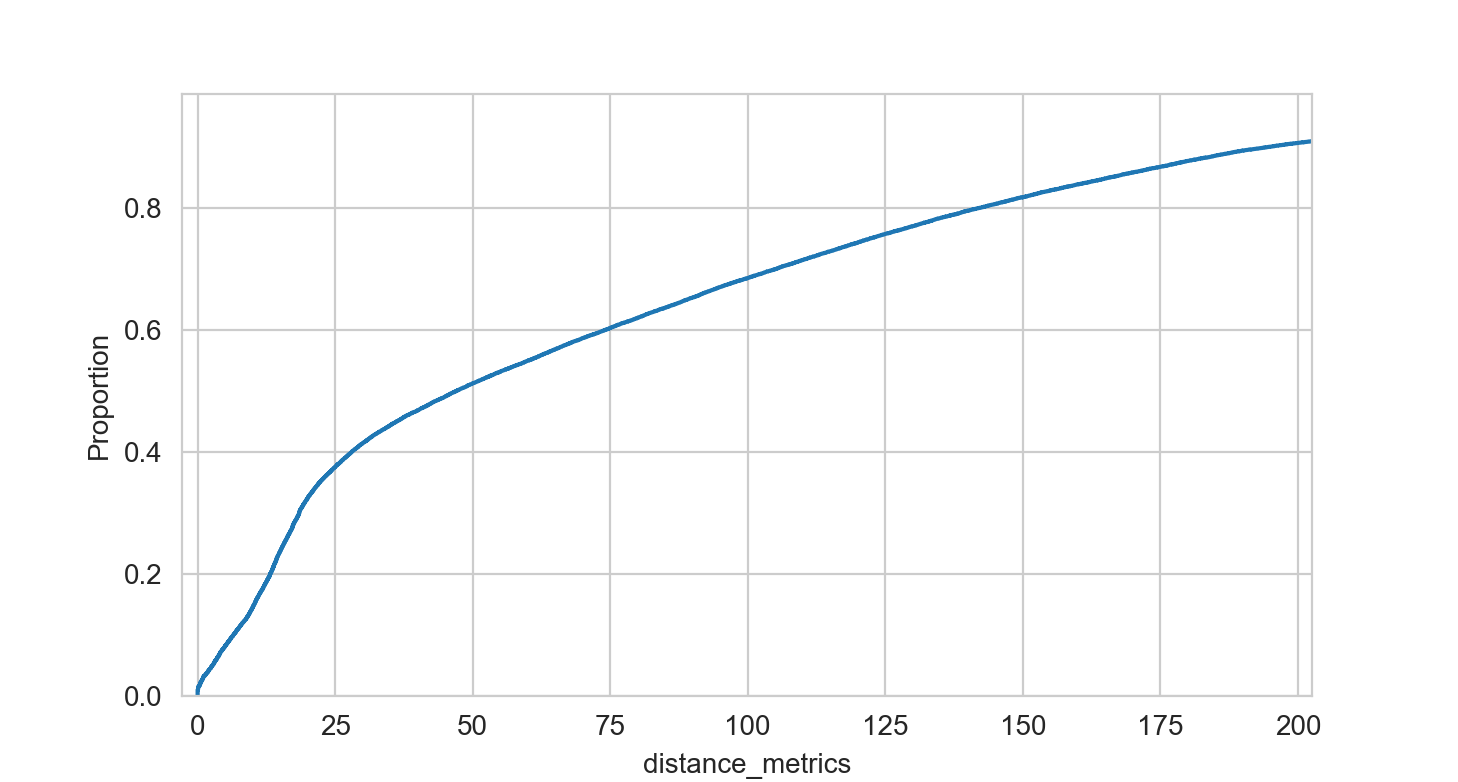

<AxesSubplot:xlabel='distance_metrics', ylabel='Proportion'>

In [264]:
sns.ecdfplot(df.distance_metrics.apply(lambda x: x['mean_distance']))

#### Tickets within 7 days

Filter out accounts with <= 30 days between first and last event

In [487]:
df['history_len'] = df.timestamps.apply(lambda x: diff_days(x[-1], x[0], abs_val=True))

In [488]:
df_gt30 = df[(df.event_ticket_distances.map(lambda x: bool(x))) & (df.history_len>30)].copy()

<IPython.core.display.Javascript object>


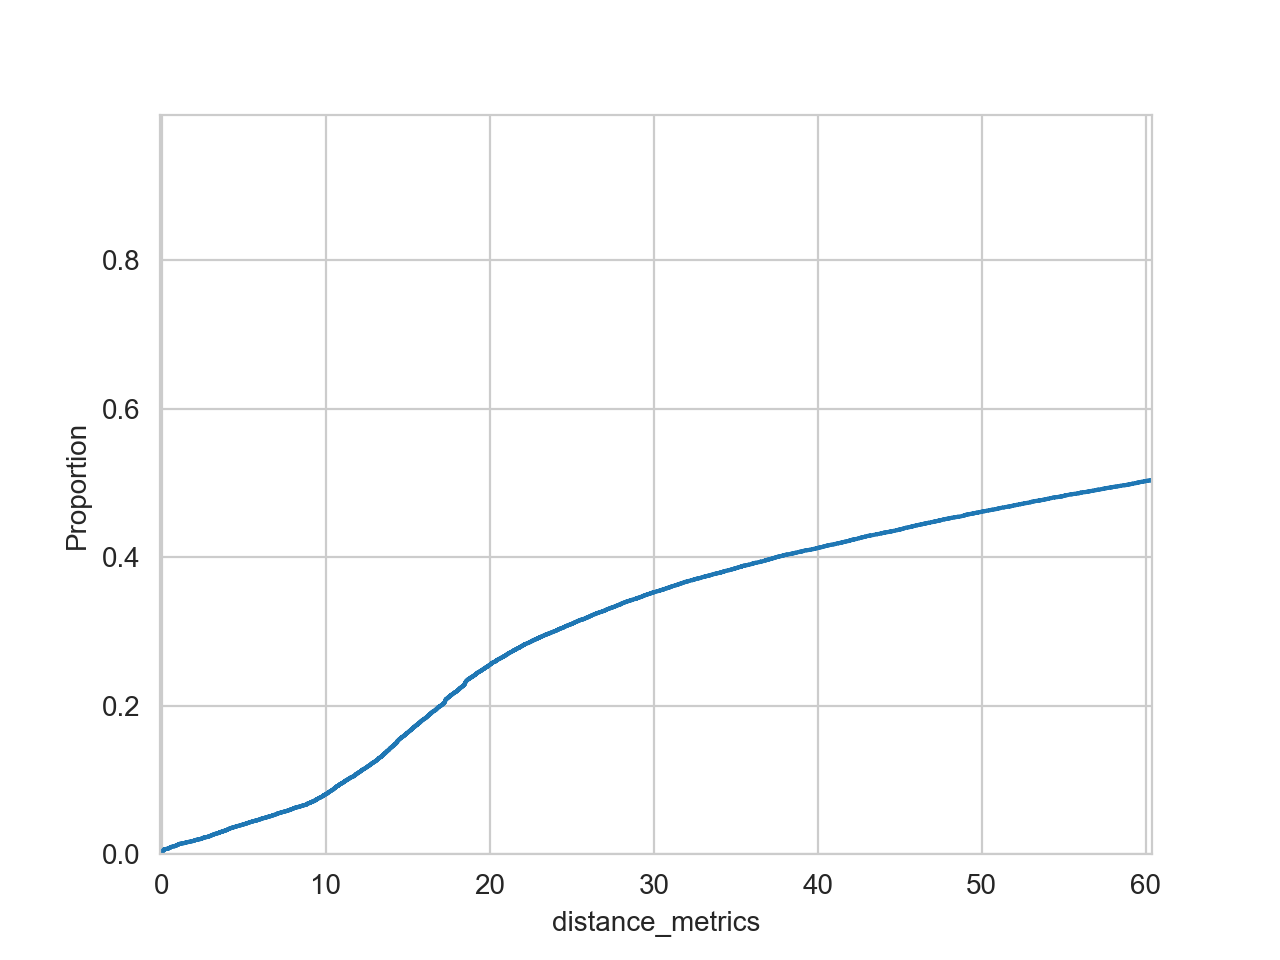

<AxesSubplot:xlabel='distance_metrics', ylabel='Proportion'>

In [391]:
sns.ecdfplot(df_gt30.distance_metrics.apply(lambda x: x['mean_distance']))

In [412]:
from collections import Counter
from functools import reduce
import operator

In [489]:
df_gt30.distance_metrics.apply(lambda x: x['event_7days']).ravel()[:3]

array([{'new_business_7days': Counter({False: 2})},
       {'renewal_7days': Counter({False: 2}), 'del_start_7days': Counter({False: 4}), 'del_exit_7days': Counter({False: 4})},
       {'renewal_7days': Counter({False: 2}), 'del_start_7days': Counter({False: 2}), 'del_exit_7days': Counter({True: 1, False: 1}), 'endorsement_7days': Counter({False: 2, True: 2})}],
      dtype=object)

In [431]:
def add_dict_counter(d1, d2):
    init = {}
    d2_unq = set(d2.keys())
    for k in d1:
        if k in d2:
            init[k] = d1[k] + d2[k]
            d2_unq.remove(k)
        else:
            init[k] = d1[k]
    for k in d2_unq:
        init[k] = d2[k]
    return init

In [432]:
reduce(add_dict_counter, [{'renewal_7days': Counter({False: 2}), 'del_start_7days': Counter(
    {False: 4})}, {'renewal_7days': Counter({False: 2})}, {'renewal_10days': Counter({True: 2})}])

{'renewal_7days': Counter({False: 4}),
 'del_start_7days': Counter({False: 4}),
 'renewal_10days': Counter({True: 2})}

In [495]:
counts = reduce(add_dict_counter, df_gt30.distance_metrics.apply(lambda x: x['event_7days']).ravel())
cdf = pd.DataFrame(counts).transpose()
cdf.apply(lambda x: x[True]/sum(x), axis=1).sort_values()

renewal_7days          0.085444
del_start_7days        0.108223
new_business_7days     0.163556
del_exit_7days         0.177330
endorsement_7days      0.270878
reinstatement_7days    0.272936
cancellation_7days     0.326526
dtype: float64

In [496]:
counts = reduce(add_dict_counter, df_gt30.distance_metrics.apply(lambda x: x['event_1day']).ravel())
cdf = pd.DataFrame(counts).transpose()
cdf.apply(lambda x: x[True]/sum(x), axis=1).sort_values()

del_start_1day        0.022446
renewal_1day          0.024674
del_exit_1day         0.065159
reinstatement_1day    0.069588
new_business_1day     0.086437
cancellation_1day     0.101997
endorsement_1day      0.103028
dtype: float64

30% of tickets occur within 7 days of cancellations, endorsements, reinstatements.

In [492]:
pd.value_counts(np.hstack(df_gt30.event_ticket_distances.apply(lambda x:list(x.keys())).ravel()))
# counts = reduce(add_dict_counter, df_gt30.distance_metrics.apply(lambda x: x['event_7days']).ravel())
# df_gt30.head(2)

del_start        31051
del_exit         29660
endorsement      20244
new_business     19783
renewal          18755
cancellation     12377
reinstatement     2346
dtype: int64

In [462]:
emd = reduce(add_dict_counter, df_gt30.distance_metrics.apply(lambda x: x['event_mean_distances']).ravel())

In [467]:
for k,v in emd.items():
    print(f"{k}:{round(v/40959,0)}")

new_business_mean:59.0
del_start_mean:73.0
renewal_mean:49.0
del_exit_mean:64.0
endorsement_mean:31.0
cancellation_mean:12.0
reinstatement_mean:3.0


## Test

In [307]:
test = 'ab'

In [306]:
df.distance_metrics.loc[0]

defaultdict(dict,
            {'mean_distance': 16.55,
             'event_mean_distances': defaultdict(float,
                         {'new_business_mean': 16.6, 'del_start_mean': 16.5}),
             'event_7days': defaultdict(float,
                         {'new_business_7days': [False],
                          'del_start_7days': [False]})})

In [333]:
graph = {
  'A' : ['B','C'],
  'B' : ['D', 'E'],
  'C' : ['F'],
  'D' : [],
  'E' : ['F'],
  'F' : []
}

In [337]:
def bfs(visited, graph, node, query=None):
    #add root to visited and Q
    visited.append(node)
    queue.append(node)

    while queue:
        #pop Q element and print/check
        s = queue.pop(0)
        print(s, end=" ")
        if s == query:
            print("Found!")
            break
        for neighbour in graph[s]:
            if neighbour not in visited:
                visited.append(neighbour)
                queue.append(neighbour)

In [ ]:
memo = {0: 0, 1: 1}

def fib(n):
    if n in memo:  # Base case
        return memo[n]
    # Compute and memo the Fibonacci number
    memo[n] = fib(n - 1) + fib(n - 2)  # Recursion
    return memo[n]

In [340]:
visited = [] # List to keep track of visited nodes.
queue = []     #Initialize a queue
bfs(visited, graph, 'A', query='D')

A B C D Found!


In [347]:
def dfs(visited, graph, node, query=None):
    if node not in visited:
        print (node)
        if node==query:
            print("Found!")
            
        visited.add(node)
        for neighbour in graph[node]:
            dfs(visited, graph, neighbour, query = query)

In [348]:
# Driver Code
visited = set() # Set to keep track of visited nodes.
dfs(visited, graph, 'A', query='B')

A
B
Found!
C
F


In [349]:
test = {"a":5}

In [353]:
5 in test

False

In [ ]:
list.pop()

### Complexity  

- Mergesort: best:1/2 nlog(n), average, worst: nlog(n)
- Quicksort: best: nlog(n), average: 2nlog(n), worst: 1/2 n**2
- binary search: search - log(n), insert/delete: n
- sets
->x in set, average: O(1), worst O(n)
- dict: k in d, get, set , delete - average O(1), worst O(n)
- lists: append, pop (last) - average O(1), pop(intermediate), insert, delete - average O(n)

### Algos. 
- Finding path: DFS
- Shortest path (fewest edges): BFS